# **Unsupervised learning**

## Import All Packages
Add all imports needed for this notebook to run

In [ ]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.patches as mpatches

# Text Clustering And Dimension Reduction

I will cluster fake news using `k-means` and visualize the clustering using PCA.

**Import the Fake News Dataset from Kaggle**

Navigate to https://www.kaggle.com. Then go to the [Account tab of your user profile](https://www.kaggle.com/me/account) and select Create API Token. This will trigger the download of kaggle.json, a file containing your API credentials.

Then run the cell below and click the upload button to upload kaggle.json to your Colab runtime.

After uploading the kaggle.json the fake news dataset will be copy to the enviroment in the '/content' directory. You will see the two files 'Fake.csv' and 'True.csv'.

For more about the dataset you can read [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

In [ ]:
from google.colab import files

# upload kaggle.json file using user prompt
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# download the dataset
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

# extract the files
!unzip '/content/fake-and-real-news-dataset.zip'

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes
 88% 36.0M/41.0M [00:00<00:00, 110MB/s]
100% 41.0M/41.0M [00:00<00:00, 115MB/s]
Archive:  /content/fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                


## 1. Read the csv files and create one single dataframe

*   Create a dataframe which is the join of the two files 'Fake.csv' and 'True.csv'.
*   Extract the 'text' column from each dataframe (droping title, subject and date columns).
*   Create a single dataframe containing a text column and a label column (fake=0, real=1).

In [ ]:

# Example for reading one file. It will work if the previous step was successful.
fake_df = pd.read_csv('/content/Fake.csv')
true_df = pd.read_csv('/content/True.csv')

#create pandas df for the 2 datasets
new_fake = pd.DataFrame(columns=('text','label'))
new_true = pd.DataFrame(columns=('text','label'))

#create new column of label with value fake=0 and real=1
new_fake['text'] = fake_df['text']
new_fake['label'] = 0
new_true['text'] = true_df['text']
new_true['label'] = 1

#join the 2 datasets
frames = [new_fake, new_true]
combined_df = pd.concat(frames)


## 2. Cluster the samples into 2 clusters (real and fake) 

*   Generate TF-IDF features by applying the TfidfVectorizer preprocessor using 1000 features (`max_features=1000`).
* Scale the data.
*    Apply k-Means algorithm on the TF-IDF features using n_clusters=2.

In [ ]:
#split tha dataset to x and y 
x = combined_df['text']
y = combined_df['label']

#Generate TF-IDF features with TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=1000,stop_words='english',analyzer='word')
X = tfidf_v.fit_transform(x).toarray()

# Standardize the data to have a mean of ~0 and a variance of 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

#apply the K-means algorithm
kmns =  KMeans(n_clusters=2,random_state=42)
clustered = kmns.fit_predict(X)


## 3. Visualize using scatter plot
The data is high dimensional, so for visualization purpose, we will perform a dimensionality reduction suing PCA.

* Apply PCA
*   Visualize the clustering in 2d using first two PCs.
*   Visualize the clustering in 3d using first three PCs.

Notes:

*   In clustering visualization it's important to also visualize the centroids.
* Visualize using matplotlib scatter function. It can be used to plot 2D or 3D scatter plots.

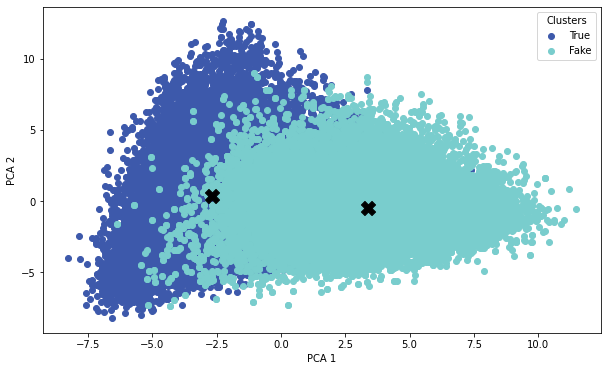

In [ ]:
#Apply PCA
pca = PCA(n_components=2,random_state=42)
pca_result_2 = pca.fit_transform(X)
centers = pca.transform(kmns.cluster_centers_)

#Visualize the clustering in 2D
y_true_labels = y.to_numpy(dtype='int32', copy=False)
PCA_df = pd.DataFrame(pca_result_2)
PCA_df['cluster'] = y_true_labels
PCA_df.columns = ['x1','x2','cluster']
true = PCA_df[PCA_df['cluster']==1]
fake = PCA_df[PCA_df['cluster']==0]
plt.figure(figsize=(10,6))
plt.scatter(true['x1'], true['x2'],c='#3D59AB',label ='True')
plt.scatter(fake['x1'], fake['x2'],c='#79CDCD',label ='Fake')
plt.scatter(x=centers[:,0],y=centers[:,1],s=200,c="k",marker="X")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc="upper right", title="Clusters")


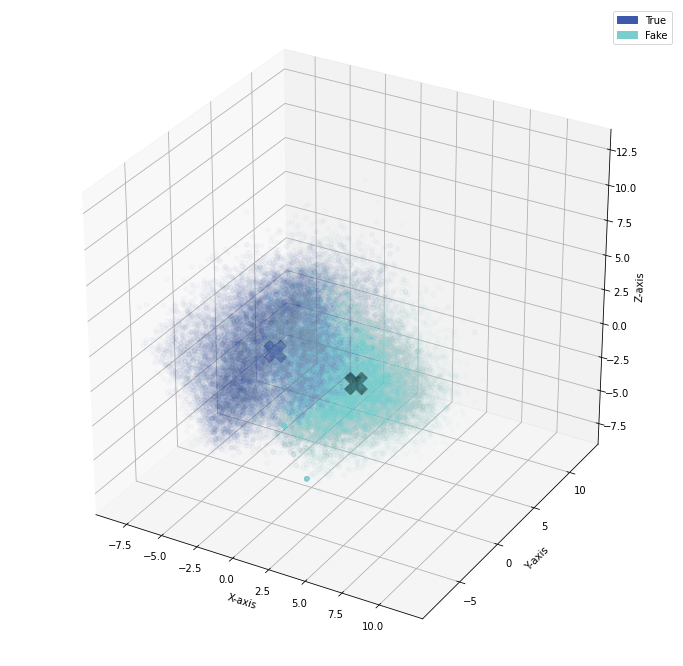

In [ ]:
#apply PCA for 3
pca = PCA(n_components=3,random_state=42)
pca_result_3 = pca.fit_transform(X)
centers = pca.transform(kmns.cluster_centers_)

#Visualize the clustering in 3D
PCA_df = pd.DataFrame(pca_result_3)
PCA_df['cluster'] = y_true_labels
PCA_df.columns = ['x1','x2','x3','cluster']
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot( projection='3d')

# Generate the values
true = PCA_df[PCA_df['cluster']==1]
fake = PCA_df[PCA_df['cluster']==0]

True_patch = mpatches.Patch(color='#3D59AB', label='True')
Fake_patch = mpatches.Patch(color='#79CDCD', label='Fake')

# Plot the values
ax.scatter(true['x1'], true['x2'],true['x3'],c='#3D59AB',label ='True',alpha=0.02)
ax.scatter(fake['x1'], fake['x2'], fake['x3'],c='#79CDCD',label ='Fake',alpha=0.02)
ax.scatter(centers[:,0],centers[:,1],centers[:,2],s=500,c="k",marker="X")
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend(handles=[True_patch, Fake_patch])


## 4. Performance evaluation 
### How did our clustering perform against the real labels?

We do have the true lables (fake/real), but we don't know which cluster correspond to which label. Therefore, we check the two options:

*   Define cluster 1 as fake and cluster 2 as real. What is the accuracy?
*   Define cluster 1 as true and cluster 2 as fake. What is the accuracy?

In [ ]:
#calculate the accuracy when cluster 1 as fake and cluster 2 as true
y_true = y
y_pred = clustered
print("The Accuracy when cluster 1 as fake and cluster 2 as true: ",accuracy_score(y_true, y_pred))

#replace the clusters value so that cluster 1 as true and cluster 2 as fake
new_y_pred = y_pred
new_y_pred[new_y_pred == 1] = 2
new_y_pred[new_y_pred == 0]  = 1
new_y_pred[new_y_pred == 2]  = 0
#calculate the accuracy when cluster 1 as true and cluster 2 as fake
print("The Accuracy when cluster 1 as true and cluster 2 as fake: ",accuracy_score(y_true, new_y_pred))

The Accuracy when cluster 1 as fake and cluster 2 as true:  0.8709742082052653
The Accuracy when cluster 1 as true and cluster 2 as fake:  0.12902579179473472


### 5.I wanted to find  the optimal `k` 
What is the best k for clustering?

* Cluster using a range of `k` (up to 20) and compare the SSD and the Silhouette values for every k.
* Plot SSD vs. k and Silhouette score vs. k.

Notes:
* You can get the SSD of a clustering using the `inertia_` attribute of the model.
* Silhouette score using `silhouette_score` function from `sklearn.metrics`. This function accept the model and the data.

In [ ]:
#Elbow method
inertias =[]
s_score = []
K = range(2, 21)

for k in K:
	kmeanModel = KMeans(n_clusters=k,random_state=42)
	clustered = kmeanModel.fit_predict(X)
	inertias.append(kmeanModel.inertia_)
	s_score.append(silhouette_score(X = X,labels = kmeanModel.labels_,sample_size = 300))


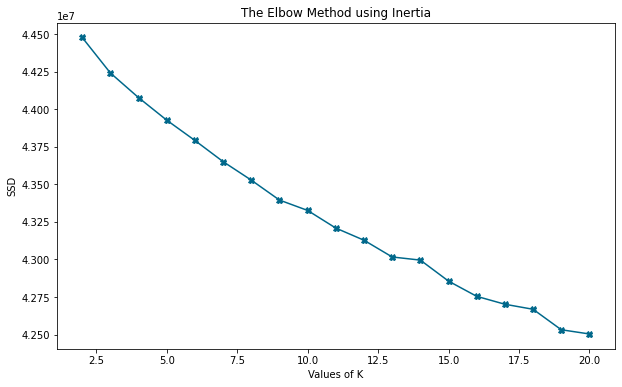

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(K, inertias,'-bX',color="#00688B")
plt.xlabel('Values of K')
plt.ylabel('SSD')
plt.title('The Elbow Method using Inertia')
plt.show()

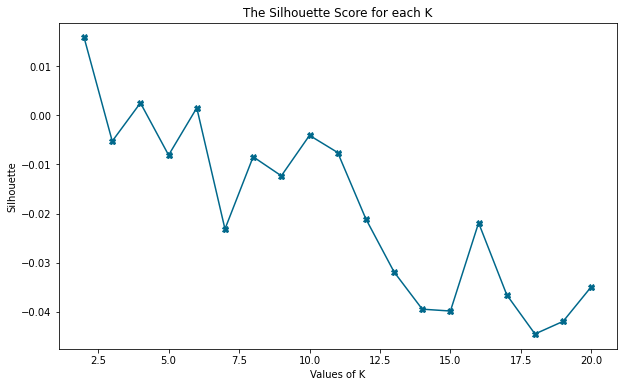

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(K, s_score,'-bX',color="#00688B")
plt.xlabel('Values of K')
plt.ylabel('Silhouette')
plt.title('The Silhouette Score for each K')
plt.show()

### 6. What is the optimal k for clustering?

* Explain.
* If optimal k!=2 what can be a good explanation for this?

**Answer:**
The optimal k for clustering is 2. We can see at the first graph that the elbow doesnt show any significant results, and for the second graph that the highest silhouette score is for k=2. But the silhouette score for k=2 is still very low so we cannot assume that this is the optimal k for the clustering, only that it is the best k from the range we examined.

A possible reason for optimal k != 2 is that when we used the TF-IDF transformer, it created for each sample a vector based on the words in the sample. As a result of that the clustering was not necessarily based on the clustering of true or fake news, But was based on a resemblance between the words themselves. Another possible reason is that as we can see at the plotting of the data in question 3 there is a lot of overlapping in the data itself which can make it alot harder to seperate the data.

# 7. PCA then k-means
This time, lets try to change the order.
1. Generate TF-IDF 1000 features
2. Run PCA
3. Run k-means
4. Plot 2D and 3D scatter plots
5. Estimate the accuracy according to true labels.
6. Explain how is it compared to the previous approach, where clustering is performed w/o PCA.


In [ ]:

x = combined_df['text']
y = combined_df['label']

#Generate TF-IDF features with TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=1000,stop_words='english',analyzer='word')
X = tfidf_v.fit_transform(x).toarray()

# Standardize the data to have a mean of ~0 and a variance of 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

#PCA 
pca = PCA(n_components=1000)
pca_result = pca.fit_transform(X)

#K-MEANS
kmns =  KMeans(n_clusters=2,random_state=42)
clustered = kmns.fit_predict(pca_result)



The Accuracy is:  0.8709742082052653


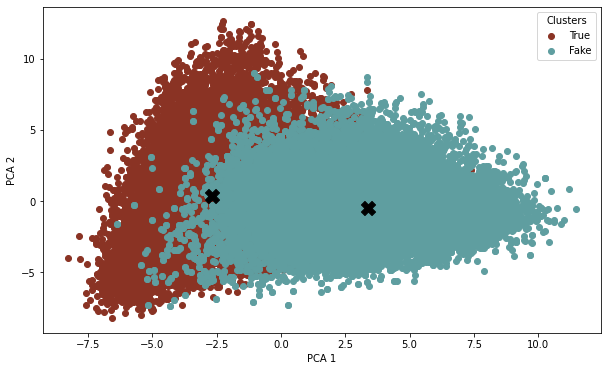

In [ ]:
#Plot PCA for 2D
PCA_df = pd.DataFrame()
centers = kmns.cluster_centers_
y_true_labels = y.to_numpy(dtype='int32', copy=False)
PCA_df['cluster'] = y_true_labels
PCA_df['x1'] = pca_result[:,0]
PCA_df['x2'] = pca_result[:,1]
true = PCA_df[PCA_df['cluster']==1]
fake = PCA_df[PCA_df['cluster']==0]
plt.figure(figsize=(10,6))
plt.scatter(true['x1'], true['x2'],c='#8A3324',label ='True')
plt.scatter(fake['x1'], fake['x2'],c='#5F9EA0',label ='Fake')
plt.scatter(x=centers[:,0],y=centers[:,1],s=200,c="k",marker="X")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(loc="upper right", title="Clusters")


#Accuracy for 2D 
y_true = y
y_pred = clustered
print("The Accuracy is: " ,accuracy_score(y_true, y_pred))

In [ ]:
x = combined_df['text']
y = combined_df['label']

#Generate TF-IDF features with TfidfVectorizer
tfidf_v = TfidfVectorizer(max_features=1000,stop_words='english',analyzer='word')
X = tfidf_v.fit_transform(x).toarray()

# Standardize the data to have a mean of ~0 and a variance of 1
scaler = StandardScaler()
X = scaler.fit_transform(X)

#PCA 
pca = PCA()
pca_result = pca.fit_transform(X)

#K-MEANS
kmns =  KMeans(n_clusters=2,random_state=42)
clustered = kmns.fit_predict(pca_result)




The Accuracy is:  0.8709742082052653


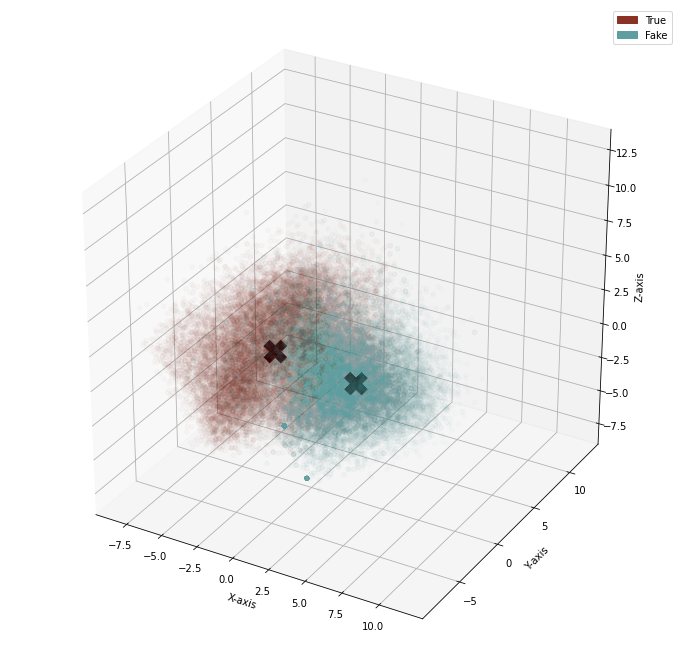

In [ ]:
#Visualize the clustering in 3D
PCA_df = pd.DataFrame()
PCA_df['cluster'] = y_true_labels
PCA_df['x1'] = pca_result[:,0]
PCA_df['x2'] = pca_result[:,1]
PCA_df['x3'] = pca_result[:,2]
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot( projection='3d')

# Generate the values
true = PCA_df[PCA_df['cluster']==1]
fake = PCA_df[PCA_df['cluster']==0]

# Plot the values
True_patch = mpatches.Patch(color='#8A3324', label='True')
Fake_patch = mpatches.Patch(color='#5F9EA0', label='Fake')
ax.scatter(true['x1'], true['x2'],true['x3'],c='#8A3324',label ='True',alpha=0.02)
ax.scatter(fake['x1'], fake['x2'], fake['x3'],c='#5F9EA0',label ='Fake',alpha=0.02)
scatter = ax.scatter(centers[:,0],centers[:,1],centers[:,2],s=500,c='black',marker="X",alpha=1)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.legend(handles=[True_patch, Fake_patch])


#Accuracy for 2D 
y_true = y
y_pred = clustered
print("The Accuracy is: " ,accuracy_score(y_true, y_pred))

**Answer:** We can see that the accuracy hasn't changed from running Kmeans and then PCA to running PCA and than Kmeans. An explanation to this result can be the use of PCA. we use PCA to reduce the dimansions of the data and clean noises from the data, meaning that when there are a lot of noises it can benefit the model and when there no noises it can be bad for the model. In our situation the PCA didnt affect the model which means that the dimentions we reduced werent good nor bad for the model. 

# **Another Analysis**
Redo the same analysis, but this time using the MNIST data set. Notice that this time there are actually 10 'true' clusters.

1. What is the accuracy of the clustering when using k=10?
2. What is the optimal k?
3. How do the results changes if you first run PCA?

In [ ]:
from keras.datasets import mnist
from sklearn import metrics
(x_train, y_train), (x_test, y_test) = mnist.load_data()


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
# Data Normalization
# Conversion to float
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')

# Normalization
x_train = x_train/255.0
x_test = x_test/255.0

# Reshaping input data
X_train = x_train.reshape(len(x_train),-1)
X_test = x_test.reshape(len(x_test),-1)

In [ ]:
#K-MEANS
kmns =  KMeans(n_clusters=10,random_state=17)
clustered = kmns.fit_predict(X_train)

#PCA
pca = PCA()
pca_result = pca.fit_transform(X_train)

#Define Clusters by majority voting
df =pd.DataFrame()
df['true label'] = y_train
df['pred label'] = clustered
new_df = df.groupby(['pred label']).agg(lambda x:x.value_counts().index[0])
new_df =new_df.to_dict()
new_df = new_df['true label']
#update the Clusters
for key,val in new_df.items():
    clustered[clustered==key] = val
   
print("The Accuracy of the clustering when using k=10: " ,accuracy_score(clustered,y_train))

The Accuracy of the clustering when using k=10:  0.42191666666666666


In [ ]:
#Elbow method
inertias =[]
s_score = []
K = [10,16,32,64,144,256,300,512]

for k in K:
		# Initialize the K-Means model
		kmeanModel = KMeans(n_clusters=k,random_state=17)
		# Fitting the model to training set
		clustered = kmeanModel.fit_predict(X_train)
		
		#Define Clusters by majority voting
		df =pd.DataFrame()
		df['true label'] = y_train
		df['pred label'] = clustered
		new_df = df.groupby(['pred label']).agg(lambda x:x.value_counts().index[0])
		new_df =new_df.to_dict()
		new_df = new_df['true label']
		#update the Clusters
		for key,val in new_df.items():
				clustered[clustered==key] = val

		print("Number of clusters is: {}".format(k))
		print("Inertia : {}".format(kmeanModel.inertia_))
		print('Accuracy score : {}'.format(accuracy_score(clustered,y_train)))
		print('------------------------')
		print('\n')


Number of clusters is: 10
Inertia : 2352826.75
Accuracy score : 0.42191666666666666
------------------------


Number of clusters is: 16
Inertia : 2183778.0
Accuracy score : 0.5804333333333334
------------------------


Number of clusters is: 32
Inertia : 1966337.5
Accuracy score : 0.7184833333333334
------------------------


Number of clusters is: 64
Inertia : 1781627.25
Accuracy score : 0.8027333333333333
------------------------


Number of clusters is: 144
Inertia : 1594377.0
Accuracy score : 0.8596
------------------------


Number of clusters is: 256
Inertia : 1474652.75
Accuracy score : 0.9027333333333334
------------------------


Number of clusters is: 300
Inertia : 1442347.875
Accuracy score : 0.9005666666666666
------------------------


Number of clusters is: 512
Inertia : 1337866.125
Accuracy score : 0.92545
------------------------




**Answer**: The optimal k is 512. We can see that as we increase the value of k the accuracy is improving and the inertia in decreasing.This might seem strange because we only have 10 digits, but since we are trying to cluster hand-written digits, there are many ways to write one digit and therefore we need more than 1 cluster to represent the images of a particular digit.

In [ ]:
#PCA 
pca = PCA()
pca_result = pca.fit_transform(X_train)

#K-MEANS
kmns =  KMeans(n_clusters=10,random_state =17)
clustered = kmns.fit_predict(pca_result)

#Define Clusters by majority voting
df =pd.DataFrame()
df['true label'] = y_train
df['pred label'] = clustered
new_df = df.groupby(['pred label']).agg(lambda x:x.value_counts().index[0])
new_df =new_df.to_dict()
new_df = new_df['true label']
#update the Clusters
for key,val in new_df.items():
    clustered[clustered==key] = val

    
print("The Accuracy when using PCA before Kmeans is: " ,accuracy_score(y_train, clustered))

The Accuracy is:  0.42191666666666666


**Answer** :  When we preformed Kmeans before PCA the accuracy was 0.421916666. But when we pfeformed PCA before Kmeans the Accuracy hasnt changed. We can assume that the dimenssion reduction performed by the PCA hasnt affected the results of the model.